# Quick, Draw! Doodle Recognition Challenge

PLEASE READ MY BLOG POST : https://medium.com/@bouteillon1981/10-lessons-learned-from-participating-to-google-ai-challenge-268b4aa87efa

In [1]:
%matplotlib inline

import ast
from pathlib import Path
import pprint
import sqlite3

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import torch

from fastai import *
from fastai.vision import *
from fastai.callbacks import *
import pretrainedmodels
import torchvision

from tqdm import tqdm

Let's define some hyper-parameters for our notebook

In [2]:
LIMIT_SAMPLES = 340*1_000
NUM_VAL = 34_000
sz = 128
lw = 1
bs = 1024

### Drawing functions

`list2drawing` convert a list of strokes to an image.

Some ideas come from:

Beluga's kernel: https://www.kaggle.com/gaborfodor/greyscale-mobilenet-lb-0-892

Radek's post: https://www.kaggle.com/c/quickdraw-doodle-recognition/discussion/69409

In [3]:
BASE_SIZE = 256
border = 2  # keep some margin with image border

shift_colors = (
    (255, 0, 0),
    (255, 128, 0),
    (255, 255, 0),
    (128, 255, 0),
    (0, 255, 0),
    (0, 255, 128),
    (0, 255, 255),
    (0, 128, 255),
    (0, 0, 255),
    (128, 0, 255),
    (255, 0, 255),
    (255, 0, 128)
)


def list2drawing(raw_strokes, size):
    img = np.zeros((size, size, 3), np.uint8)
    coef = (size - 2 * lw - 2 * border) / (BASE_SIZE - 1)
    nb_stokes = len(raw_strokes)
    for t, stroke in enumerate(raw_strokes[::-1]):
        rgb = shift_colors[(nb_stokes-t-1)%12]

        for i in range(len(stroke[0]) - 1):
            p1 = (int(coef * stroke[0][i] + lw + border), int(coef * stroke[1][i] + lw+ border))
            p2 = (int(coef * stroke[0][i + 1] + lw + border), int(coef * stroke[1][i + 1] + lw + border))
            _ = cv2.line(img, p1, p2, rgb, lw, cv2.LINE_AA)
    return img


def drawing2tensor(drawing):
    rgb = drawing.transpose(2,0,1).astype(np.float32)
    return torch.from_numpy(rgb)

### Metrics

`map3` is the metric used for this competition

These functions are from https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py

In [4]:
def apk(actual, predicted, k=10):
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

def map3(preds, targs):
    predicted_idxs = preds.sort(descending=True)[1]
    top_3 = predicted_idxs[:, :3]
    res = mapk([[t] for t in targs.cpu().numpy()], top_3.cpu().numpy(), 3)
    return torch.tensor(res)

### Submission Functions

In [5]:
def top_3_preds(preds):
    return np.argsort(preds.numpy())[:, ::-1][:, :3]


def top_3_pred_labels(preds, classes):
    top_3 = top_3_preds(preds)
    labels = []
    for i in range(top_3.shape[0]):
        labels.append(' '.join([classes[idx] for idx in top_3[i]]))
    return labels


def create_submission(test_preds, test_dl, name, classes):
    key_ids = test_dl.dataset.x.items
    labels = top_3_pred_labels(test_preds, classes)
    sub = pd.DataFrame({'key_id': key_ids, 'word': labels})
    sub.to_csv(f'{name}.csv.gz', index=False, compression='gzip')

###  Create ImageDataBunch using the data block API

In [6]:
# open database in read only mode
db = sqlite3.connect('file:/home/eric/jupyter-project/quickdraw-doodle-recognition/quickdraw_master/data/quickdraw_dataset.db?mode=ro', uri=True)
c = db.cursor()

In [7]:
# Get list of classes
c.execute('SELECT y,label from classes ORDER BY y')
db_classes = c.fetchall()
db_classes = {c[0]: c[1].replace(' ', '_') for c in db_classes}
pprint.pprint(db_classes)

{0: 'airplane',
 1: 'alarm_clock',
 2: 'ambulance',
 3: 'angel',
 4: 'animal_migration',
 5: 'ant',
 6: 'anvil',
 7: 'apple',
 8: 'arm',
 9: 'asparagus',
 10: 'axe',
 11: 'backpack',
 12: 'banana',
 13: 'bandage',
 14: 'barn',
 15: 'baseball',
 16: 'baseball_bat',
 17: 'basket',
 18: 'basketball',
 19: 'bat',
 20: 'bathtub',
 21: 'beach',
 22: 'bear',
 23: 'beard',
 24: 'bed',
 25: 'bee',
 26: 'belt',
 27: 'bench',
 28: 'bicycle',
 29: 'binoculars',
 30: 'bird',
 31: 'birthday_cake',
 32: 'blackberry',
 33: 'blueberry',
 34: 'book',
 35: 'boomerang',
 36: 'bottlecap',
 37: 'bowtie',
 38: 'bracelet',
 39: 'brain',
 40: 'bread',
 41: 'bridge',
 42: 'broccoli',
 43: 'broom',
 44: 'bucket',
 45: 'bulldozer',
 46: 'bus',
 47: 'bush',
 48: 'butterfly',
 49: 'cactus',
 50: 'cake',
 51: 'calculator',
 52: 'calendar',
 53: 'camel',
 54: 'camera',
 55: 'camouflage',
 56: 'campfire',
 57: 'candle',
 58: 'cannon',
 59: 'canoe',
 60: 'car',
 61: 'carrot',
 62: 'castle',
 63: 'cat',
 64: 'ceiling_fa

In [8]:
%%time
# Get labels for each items in our train dataset
c.execute('SELECT key_id,y FROM train')
train_labels = c.fetchall()
print('True number of labels in train:', len(train_labels))

True number of labels in train: 49707579
CPU times: user 21.5 s, sys: 10.2 s, total: 31.7 s
Wall time: 2min 10s


In [9]:
# Get a limited piece of train dataset
if LIMIT_SAMPLES is not None:
    train_labels = train_labels[::len(train_labels)//LIMIT_SAMPLES]
len(train_labels), LIMIT_SAMPLES

(340463, 340000)

In [10]:
train_labels = pd.DataFrame.from_records(train_labels, columns=['key_id', 'y'])
train_labels['y'] = train_labels['y'].map(db_classes).astype('category')
train_labels.head()

,key_id,y
0,4503599667216384,watermelon
1,4503605690236928,basketball
2,4503612736667648,passport
3,4503618898100224,saxophone
4,4503626024222720,hospital


In [11]:
%%time
# Get list of test items
c.execute('SELECT key_id FROM test')
tests = c.fetchall()
print('Number of samples in tests:', len(tests))
tests = pd.DataFrame.from_records(tests, columns=['key_id'])
tests.head()

Number of samples in tests: 112199
CPU times: user 67.3 ms, sys: 26.6 ms, total: 94 ms
Wall time: 218 ms


In [12]:
# Callback of parallel workers
from multiprocessing import Lock
lock = Lock()

def create_func(path):
    global c
    key_id = int(path)
    lock.acquire()  # meh!
    if path < 9000000000000000:
        c.execute(f'SELECT drawing from train WHERE key_id=?', (key_id,))
    else:
        c.execute(f'SELECT drawing from test WHERE key_id=?', (key_id,))
    drawing = c.fetchone()
    lock.release()
    
    if drawing is None:
        print('got None for', path)
    drawing = drawing[0]
    drawing = ast.literal_eval(drawing)
    drawing = list2drawing(drawing, size=sz)
    tensor = drawing2tensor(drawing)
    return Image(tensor.div_(255))

In [13]:
item_list = ItemList.from_df(df=train_labels, create_func=create_func, cols='key_id')

In [14]:
idxs = np.arange(item_list.items.shape[0])
np.random.shuffle(idxs)
val_idxs = idxs[:NUM_VAL]

In [15]:
item_lists = item_list.split_by_idx(val_idxs)

In [16]:
label_lists = item_lists.label_from_df(cols='y')

test_items = ItemList.from_df(df=tests, create_func=create_func, cols='key_id')
label_lists.add_test(test_items);

In [17]:
classes = label_lists.train.y.classes
classes

['watermelon',
 'basketball',
 'passport',
 'saxophone',
 'hospital',
 'bottlecap',
 'diving_board',
 'teddy-bear',
 'toothpaste',
 'traffic_light',
 'lipstick',
 'hot_dog',
 'stethoscope',
 'paintbrush',
 'key',
 'blackberry',
 'giraffe',
 'rain',
 'toothbrush',
 'snorkel',
 'piano',
 'moon',
 'pond',
 'golf_club',
 'soccer_ball',
 'mouth',
 'spider',
 'moustache',
 'strawberry',
 'crocodile',
 'The_Great_Wall_of_China',
 'tree',
 'penguin',
 'scissors',
 'face',
 'square',
 'keyboard',
 'skyscraper',
 'ant',
 'basket',
 'megaphone',
 'roller_coaster',
 'spoon',
 'cello',
 'tent',
 'whale',
 'mountain',
 'shoe',
 'steak',
 'violin',
 'truck',
 'flashlight',
 'map',
 'hamburger',
 'potato',
 'firetruck',
 'brain',
 'sea_turtle',
 'pizza',
 'television',
 'compass',
 'cannon',
 'screwdriver',
 'eyeglasses',
 'canoe',
 'The_Eiffel_Tower',
 'leg',
 'smiley_face',
 'goatee',
 'postcard',
 'baseball',
 'remote_control',
 'knee',
 'snowman',
 'flower',
 'pencil',
 'harp',
 'arm',
 'chair',
 

In [18]:
train_dl = DataLoader(label_lists.train, bs, True, num_workers=8)
valid_dl = DataLoader(label_lists.valid, 2*bs, False, num_workers=8)
test_dl = DataLoader(label_lists.test, 2*bs, False, num_workers=8)

data_bunch = ImageDataBunch(train_dl, valid_dl, test_dl)

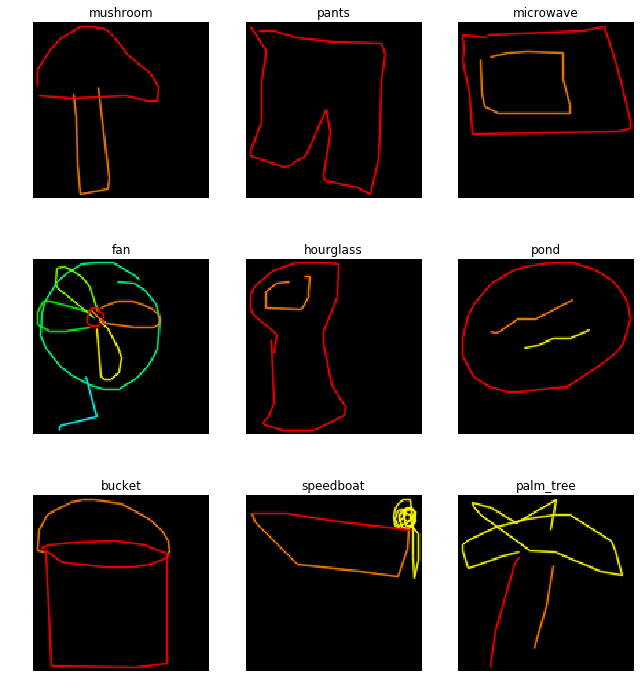

In [19]:
data_bunch.show_batch(rows=3)

### Create the CNN model

In [20]:
custom_head=nn.Sequential(
    nn.AdaptiveAvgPool2d(1),
    Flatten(),
    nn.Linear(512, len(classes))
)

In [21]:
model_name = 'resnet18-simple'
learn = create_cnn(data_bunch, models.resnet18, metrics=[accuracy, map3], pretrained=False,
                   cut=-2, split_on=None, custom_head=custom_head,
                  ).to_fp16()

In [22]:
learn.model.eval()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

### Train the model

In [23]:
name = f'{model_name}-{sz}'

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


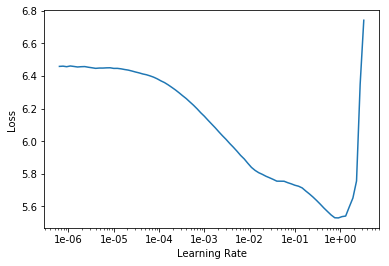

In [24]:
learn.lr_find()
learn.recorder.plot()

In [25]:
lr = 1e-2

In [26]:
learn.fit_one_cycle(4, lr)

Total time: 17:36:45
epoch  train_loss  valid_loss  accuracy  map3    
1      0.817358    0.847132    0.777118  0.840279  (4:23:41)
2      0.782329    0.800338    0.787706  0.849358  (4:23:28)
3      0.687505    0.694399    0.815824  0.870549  (4:24:33)
4      0.610510    0.612972    0.836382  0.886265  (4:25:01)



In [27]:
learn.save(f'{name}-scratch-1')

### Fine-tuning with larger images

As it is not possible to change the batch size easily with fastai, the batch size set at the beginning takes into account the model to work with below image size too

In [28]:
sz = 128+16

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


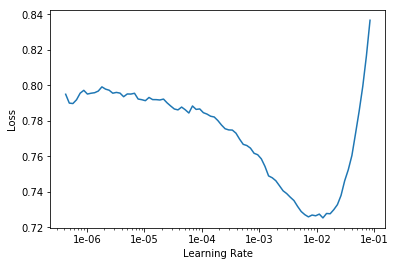

In [29]:
learn.lr_find(end_lr=2e-1)
learn.recorder.plot()

In [30]:
lr = 1e-3

In [31]:
learn.fit_one_cycle(1, lr)

Total time: 6:08:20
epoch  train_loss  valid_loss  accuracy  map3    
1      0.593504    0.579562    0.844088  0.892059  (6:08:20)



In [32]:
learn.save(f'{name}-scratch-2')

### Predict

In [33]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [34]:
create_submission(preds, data_bunch.test_dl, name, classes)

In [35]:
# !kaggle competitions submit -c quickdraw-doodle-recognition -f subs/{name}.csv.gz -m "{name}"

### Sanity check

In [36]:
result = pd.read_csv(f'{name}.csv.gz')
result.head(20)

,key_id,word
0,9000003627287624,radio stereo stove
1,9000010688666847,hockey_puck bottlecap pool
2,9000023642890129,The_Great_Wall_of_China castle camel
3,9000038588854897,mountain tent The_Eiffel_Tower
4,9000052667981386,fireplace campfire fire_hydrant
5,9000057427034623,fence jail spreadsheet
6,9000065506980882,wine_glass hourglass cup
7,9000087586309806,submarine dolphin lobster
8,9000092580281382,bracelet hand wristwatch
9,9000096661653918,hourglass vase wine_glass


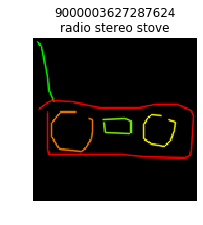

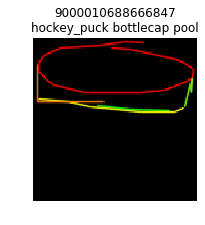

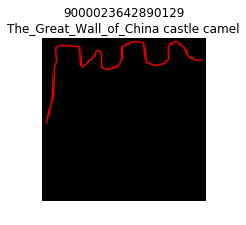

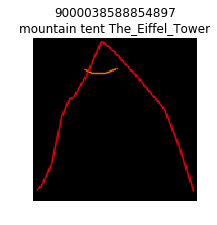

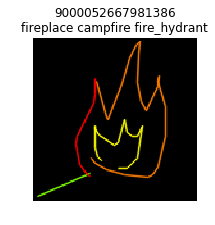

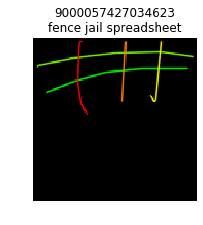

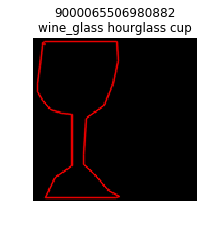

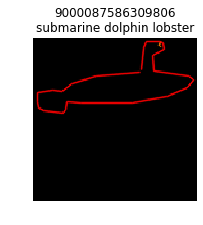

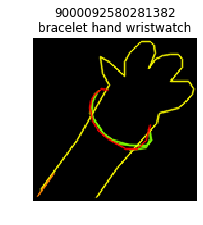

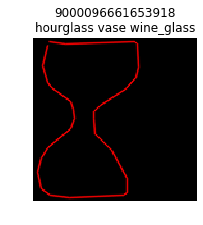

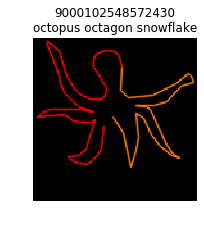

In [37]:
for i, (index, row) in enumerate(result.iterrows()):
    create_func(row.key_id).show(title=f'{row.key_id}\n{row.word}')
    if i == 10:
        break

### Save elements for Ensembling

In [38]:
torch.save(preds, f'{name}-raw_predictions.pt')

In [39]:
sub = pd.DataFrame(preds.numpy(), index=test_dl.dataset.x.items, columns=classes)
sub.to_csv(f'{name}-raw-predictions.csv.gz', compression='gzip')